In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np

# !pip install sktime
from sktime.forecasting.model_selection import temporal_train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.9 MB 4.6 MB/s 


In [4]:
data_file = "/content/gdrive/MyDrive/Colab Notebooks/4-2/AIFT/data.csv"
df = pd.read_csv(data_file,index_col='Unnamed: 0')
df = df.iloc[1:][:]
print(df.shape)
df.head()

(14145, 23)


,ma_w_x,macd_w_x,macdsignal_w_x,macdhist_w_x,rsi_w_x,ad_w_x,ts_end_x,ts_start_x,is_higher_x,offset_intra_day_x,...,macdsignal_w_y,macdhist_w_y,rsi_w_y,ad_w_y,ts_end_y,ts_start_y,is_higher_y,offset_intra_day_y,target_y,label
2021-12-02 11:12:00,32.906667,8.622361,22.457295,-13.834934,-1.847265,51515.668116,False,False,True,0.330769,...,-2.542392,1.449403,1.920541,-541806.0,False,False,False,0.330769,0.998628,NOP
2021-12-02 11:15:00,35.760000,2.547207,18.475277,-15.928070,-5.503149,25495.709956,False,False,True,0.338462,...,-2.110002,1.729559,7.159809,-309922.4,False,False,False,0.338462,0.997340,NOP
2021-12-02 11:18:00,42.043333,-2.153807,14.349460,-16.503267,-4.424460,21430.047899,False,False,True,0.346154,...,-1.723365,1.546547,2.957516,-377094.0,False,False,False,0.346154,0.998507,NOP
2021-12-02 11:21:00,46.373333,-6.761681,10.127232,-16.888913,-4.671662,15676.338589,False,False,True,0.353846,...,-1.278042,1.781292,8.215010,-245900.2,False,False,False,0.353846,0.997179,X
2021-12-02 11:24:00,53.736667,-6.298201,6.842146,-13.140346,0.011823,24676.029280,False,False,True,0.361538,...,-0.888162,1.559519,4.020271,-663077.5,False,False,False,0.361538,0.998305,NOP


In [5]:

effective_cols = [

       'ma_w_x', 'macd_w_x', 'macdsignal_w_x', 'macdhist_w_x', 'rsi_w_x', 'ad_w_x', 'is_higher_x', 
       'ts_end_x', 'ts_start_x', 'offset_intra_day_x', 
       'ma_w_y', 'macd_w_y', 'macdsignal_w_y', 'macdhist_w_y', 'rsi_w_y', 'ad_w_y', 'is_higher_y', 


       'label'
       
       ]

In [6]:
data_df = df[effective_cols].dropna(axis=0)

In [8]:
!pip install flaml
from flaml import AutoML
automl = AutoML()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 208 kB 5.3 MB/s 
     |████████████████████████████████| 2.0 MB 48.7 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
df.tail()

In [9]:
learn_split = data_df.loc[:'2022-09-30']
test_split = data_df.loc['2022-10-01':'2022-12-08']

In [10]:
X_train, X_val = temporal_train_test_split(learn_split, test_size=0.2)
X_test = test_split

In [11]:
y_train = X_train.pop('label')
y_val = X_val.pop('label')
y_test = X_test.pop('label')

In [12]:
y_train.value_counts(normalize=True)

NOP    0.910646
Y      0.048898
X      0.040456
Name: label, dtype: float64

In [ ]:
y_val.value_counts(normalize=True)

In [ ]:
y_test.value_counts(normalize=True)

In [13]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek

In [14]:
smt = SMOTETomek(random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_train, y_train)

In [15]:
from sklearn.model_selection import train_test_split
X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [16]:
automl.fit(X_resampled_train, y_resampled_train, 
          task="classification", 
          X_val=X_resampled_test, y_val=y_resampled_test, 
          time_budget=60*10, 
          log_file_name='.segment_automl_baseline2_10m.log', 
          estimator_list=["rf"])

[flaml.automl: 12-10 05:16:25] {2599} INFO - task = classification
INFO:flaml.automl:task = classification
[flaml.automl: 12-10 05:16:25] {2601} INFO - Data split method: stratified
INFO:flaml.automl:Data split method: stratified
[flaml.automl: 12-10 05:16:25] {2604} INFO - Evaluation method: holdout
INFO:flaml.automl:Evaluation method: holdout
[flaml.automl: 12-10 05:16:25] {2726} INFO - Minimizing error metric: log_loss
INFO:flaml.automl:Minimizing error metric: log_loss
[flaml.automl: 12-10 05:16:25] {2870} INFO - List of ML learners in AutoML Run: ['rf']
INFO:flaml.automl:List of ML learners in AutoML Run: ['rf']
[flaml.automl: 12-10 05:16:25] {3166} INFO - iteration 0, current learner rf
INFO:flaml.automl:iteration 0, current learner rf
[flaml.automl: 12-10 05:16:25] {3296} INFO - Estimated sufficient time budget=2604s. Estimated necessary time budget=3s.
INFO:flaml.automl:Estimated sufficient time budget=2604s. Estimated necessary time budget=3s.
[flaml.automl: 12-10 05:16:25] {3

In [17]:
# 모델 저징

'''pickle and save the automl object'''
import pickle
with open('.automl_baseline2_balanced_10m.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open('.automl_baseline2_balanced_10m.pkl', 'rb') as f:
    automl = pickle.load(f)

In [18]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best loss on validation data: {0:.4g}'.format(automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))


Best ML leaner: rf
Best hyperparmeter config: {'n_estimators': 56, 'max_features': 0.14351395385835836, 'max_leaves': 4552, 'criterion': 'gini'}
Best loss on validation data: 0.5448
Training duration of best run: 2.126 s


In [19]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
# print('Predicted labels', y_pred)
# print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)


In [20]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))

accuracy = 0.7472826086956522


In [21]:
pd.Series(y_pred).value_counts(normalize=True)

NOP    0.812112
Y      0.137034
X      0.050854
dtype: float64

In [22]:
y_test.value_counts(normalize=True)

NOP    0.912655
X      0.055512
Y      0.031832
Name: label, dtype: float64

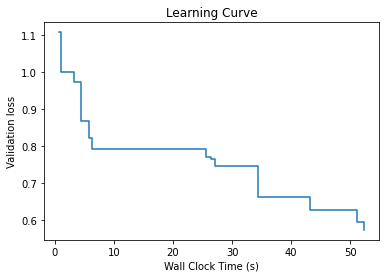

In [24]:
from flaml.data import get_output_from_log
import matplotlib.pyplot as plt
import numpy as np

time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename='.segment_automl_baseline2_10m.log', time_budget=60)

plt.title("Learning Curve")
plt.xlabel("Wall Clock Time (s)")
plt.ylabel("Validation loss")
plt.step(time_history, np.array(best_valid_loss_history), where="post")
plt.show()

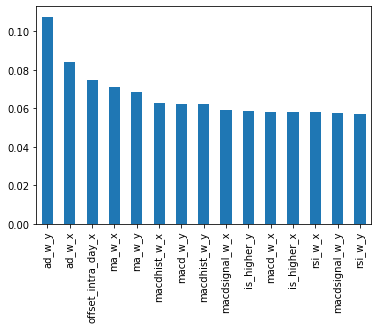

In [25]:
pd.Series(automl.feature_importances_, index=automl.feature_names_in_).sort_values(ascending=False).plot.bar()

In [26]:
from sklearn.metrics import classification_report

In [27]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         NOP       0.91      0.81      0.86      2351
           X       0.05      0.04      0.04       143
           Y       0.04      0.16      0.06        82

    accuracy                           0.75      2576
   macro avg       0.33      0.34      0.32      2576
weighted avg       0.84      0.75      0.79      2576



In [28]:
pd.Series(y_pred, index=y_test.index).astype('category').to_pickle('.y_pred_baseline2_10m.pkl')

prob_df = pd.DataFrame(y_pred_proba, columns=['NOP', 'X', 'Q'], index = y_test.index)
prob_df.to_pickle('.y_prob_baseline2_10m.pkl')

In [29]:
prob_df.X.quantile([0.25, 0.5, 0.75])

0.25    0.125000
0.50    0.196429
0.75    0.267857
Name: X, dtype: float64

In [30]:
prob_df

,NOP,X,Q
2022-10-04 11:09:00,0.428571,0.250000,0.321429
2022-10-04 11:12:00,0.625000,0.250000,0.125000
2022-10-04 11:15:00,0.607143,0.250000,0.142857
2022-10-04 11:18:00,0.571429,0.196429,0.232143
2022-10-04 11:21:00,0.607143,0.125000,0.267857
...,...,...,...
2022-12-07 13:42:00,0.410714,0.250000,0.339286
2022-12-07 13:45:00,0.482143,0.089286,0.428571
2022-12-07 13:48:00,0.482143,0.178571,0.339286
2022-12-07 13:51:00,0.517857,0.232143,0.250000
